In [70]:
### Data Collection
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [71]:
df=pd.read_csv("Netflix.csv")
print(df.head())

         Date      Open      High       Low     Close  Adj Close     Volume
0  2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
1  2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
2  2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
3  2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    6757800
4  2002-05-30  1.107857  1.107857  1.071429  1.071429   1.071429   10154200


In [72]:
closed_prices=df["Close"]
seq_len=15
mm=MinMaxScaler()
scaled_price=mm.fit_transform(np.array(closed_prices)[...,None]).squeeze()
print(scaled_price)

[0.00119131 0.00121094 0.00113448 ... 0.2785077  0.29612623 0.28728803]


In [79]:
x=[]
y=[]
for i in range(len(scaled_price)-seq_len):
    x.append(scaled_price[i:i+seq_len])
    y.append(scaled_price[i+seq_len])

In [74]:
x=np.array(x)[...,None]
y=np.array(y)[...,None]

train_x = torch.from_numpy(x[:int(0.8 * x.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * y.shape[0])]).float().unsqueeze(1)
test_x = torch.from_numpy(x[int(0.8 * x.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * y.shape[0]):]).float().unsqueeze(1)
print(train_x.shape,test_x.shape)
print(train_y.shape,test_y.shape)

torch.Size([4023, 15, 1]) torch.Size([1006, 15, 1])
torch.Size([4023, 1, 1]) torch.Size([1006, 1, 1])


10 epoch loss 0.008878961205482483
20 epoch loss 0.007005075458437204
30 epoch loss 0.005311137065291405
40 epoch loss 0.0010928750270977616
50 epoch loss 0.0003711985773406923
60 epoch loss 9.415292151970789e-05
70 epoch loss 8.478638483211398e-05
80 epoch loss 5.110435813548975e-05
90 epoch loss 3.963134440709837e-05
100 epoch loss 3.400891364435665e-05


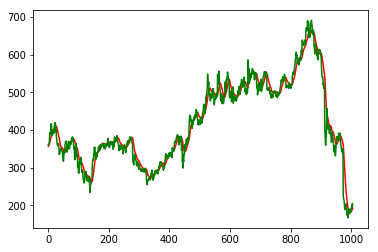

In [76]:
class Model(nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        output,(hidden,cell)=self.lstm(x)
        return self.fc(hidden[-1,:])
model=Model(1,150)

optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.MSELoss()
num_epochs=110
for epoch in range(num_epochs):
    output=model(train_x)
    loss=loss_fn(output,train_y.squeeze(1))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%10==0 and epoch!=0:
        print(epoch,"epoch loss",loss.item())
        
model.eval()
with torch.no_grad():
    output=model(test_x)
    
    
pred=mm.inverse_transform(output.numpy())
test_y_2d=test_y.reshape(-1,1)
real=mm.inverse_transform(test_y_2d.numpy())

plt.plot(pred.squeeze(),color="red",label="predicted")
plt.plot(real.squeeze(),color="green",label="real")
plt.show()